In [20]:
import numpy as np
import pandas as pd
import scanpy as sc
import pertpy as pt
import scvi

from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

sc.set_figure_params(dpi=100, frameon=False, facecolor=None)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
scvi.settings.batch_size=300

In [4]:
adata = pt.dt.norman_2019()
adata

AnnData object with n_obs × n_vars = 111255 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', '

In [5]:
scvi.model.SCVI.setup_anndata(adata, layer="counts")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
nb_models = []
mae_models = []
for seed in range(3):
    scvi.settings.seed = seed
    
    nb = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
    nb.train()
    nb_models.append(nb)
    
    adata.obsm['X_nb'] = nb.get_latent_representation()
    sc.pp.neighbors(adata, use_rep='X_nb', key_added='nn_nb')
    sc.tl.umap(adata, neighbors_key='nn_nb')
    # store UMAP separately so it's not overwritten
    adata.obsm[f'X_umap_nb_{seed}'] = adata.obsm['X_umap']

    mae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="mae")
    mae.train()
    mae_models.append(mae)
    
    adata.obsm['X_mae'] = mae.get_latent_representation()
    sc.pp.neighbors(adata, use_rep='X_mae', key_added='nn_mae')
    sc.tl.umap(adata, neighbors_key='nn_mae')
    # store UMAP separately so it's not overwritten
    adata.obsm[f'X_umap_mae_{seed}'] = adata.obsm['X_umap']
    break

[rank: 0] Global seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8fc8b6f3-b066-fc74-facd-919b65801960/1/0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 72/72: 100%|██████████| 72/72 [09:06<00:00,  7.54s/it, v_num=1, train_loss_step=8.57e+3, train_loss_epoch=8.29e+3]

`Trainer.fit` stopped: `max_epochs=72` reached.


Epoch 72/72: 100%|██████████| 72/72 [09:06<00:00,  7.59s/it, v_num=1, train_loss_step=8.57e+3, train_loss_epoch=8.29e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8fc8b6f3-b066-fc74-facd-919b65801960/1/0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 72/72: 100%|██████████| 72/72 [08:53<00:00,  7.54s/it, v_num=1, train_loss_step=2.42e+4, train_loss_epoch=2.39e+4]

`Trainer.fit` stopped: `max_epochs=72` reached.


Epoch 72/72: 100%|██████████| 72/72 [08:53<00:00,  7.41s/it, v_num=1, train_loss_step=2.42e+4, train_loss_epoch=2.39e+4]


<Axes: xlabel='epoch'>

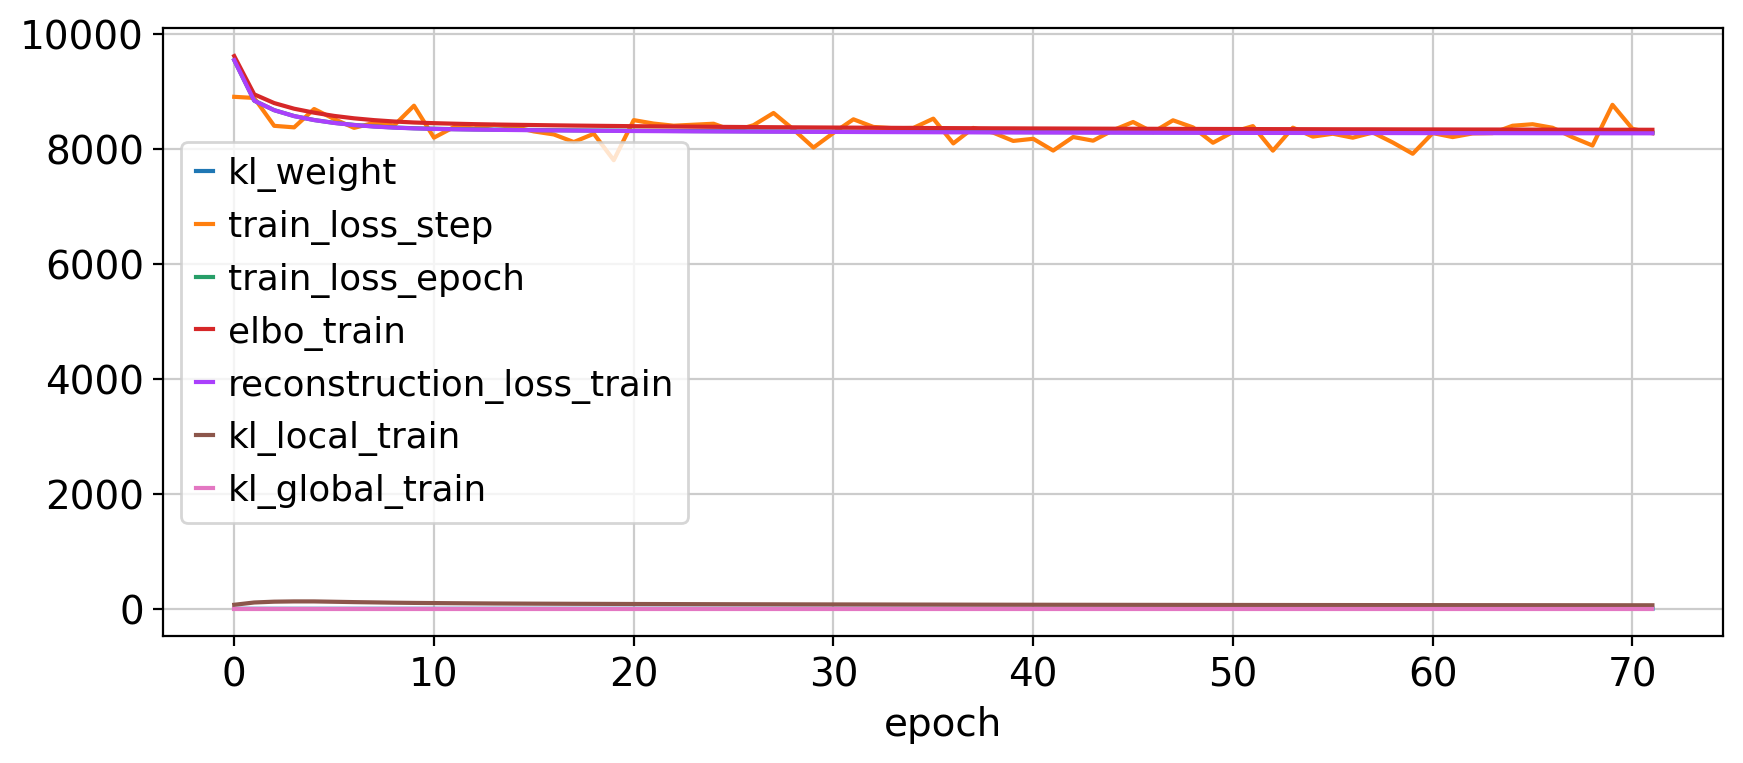

In [7]:
pd.concat(nb.history.values(), axis=1).plot(figsize=(10,4))

<Axes: xlabel='epoch'>

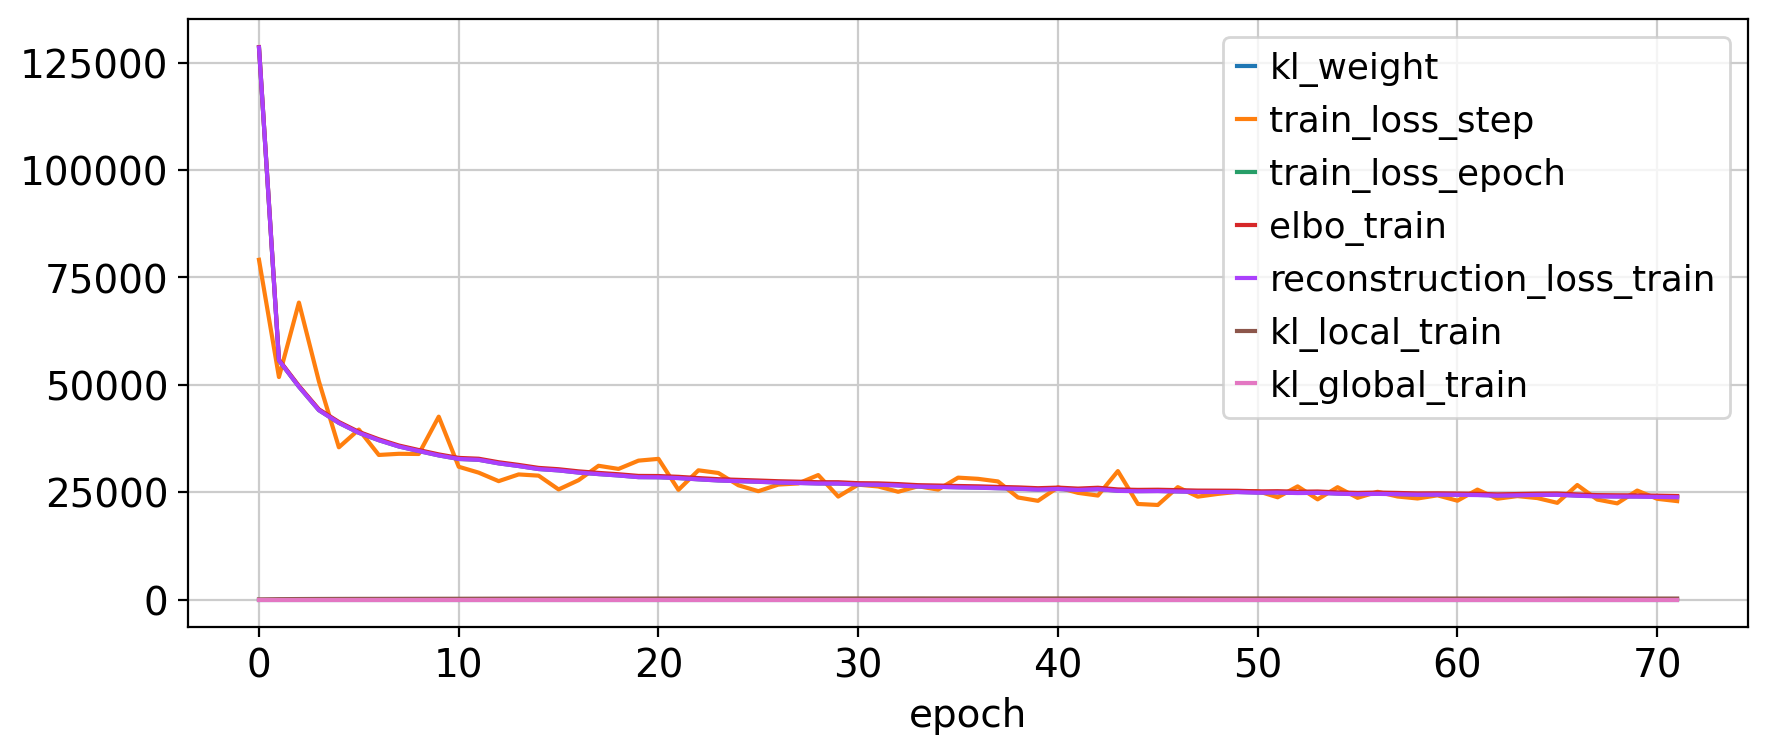

In [8]:
pd.concat(mae.history.values(), axis=1).plot(figsize=(10,4))

In [10]:
high = ['CEBPA+JUN', 'CEBPE+SPI1', 'DLX2+ZBTB10']
low = ['BAK1', 'TGFBR2']

In [11]:
adata.obs.perturbation_name.value_counts()[high + low]

CEBPA+JUN        54
CEBPE+SPI1      179
DLX2+ZBTB10      89
BAK1           1451
TGFBR2          644
Name: perturbation_name, dtype: int64

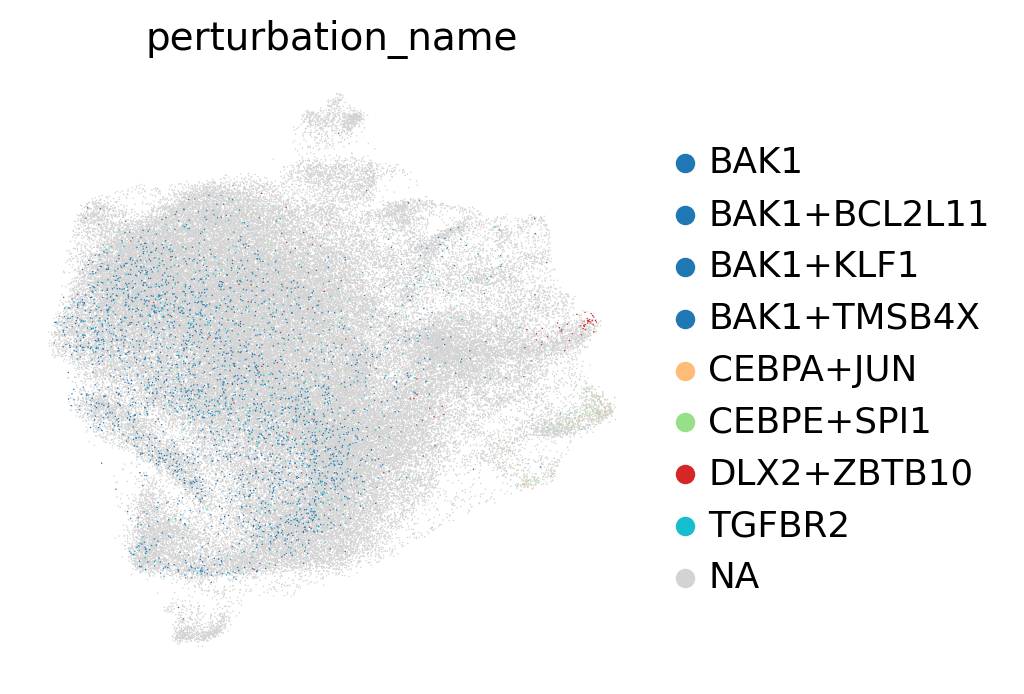

In [14]:
sc.pl.embedding(adata, color='perturbation_name', groups=high+low+['BAK1+BCL2L11', 'BAK1+KLF1', 'BAK1+TMSB4X'], basis='X_umap_nb_0', palette='tab20')

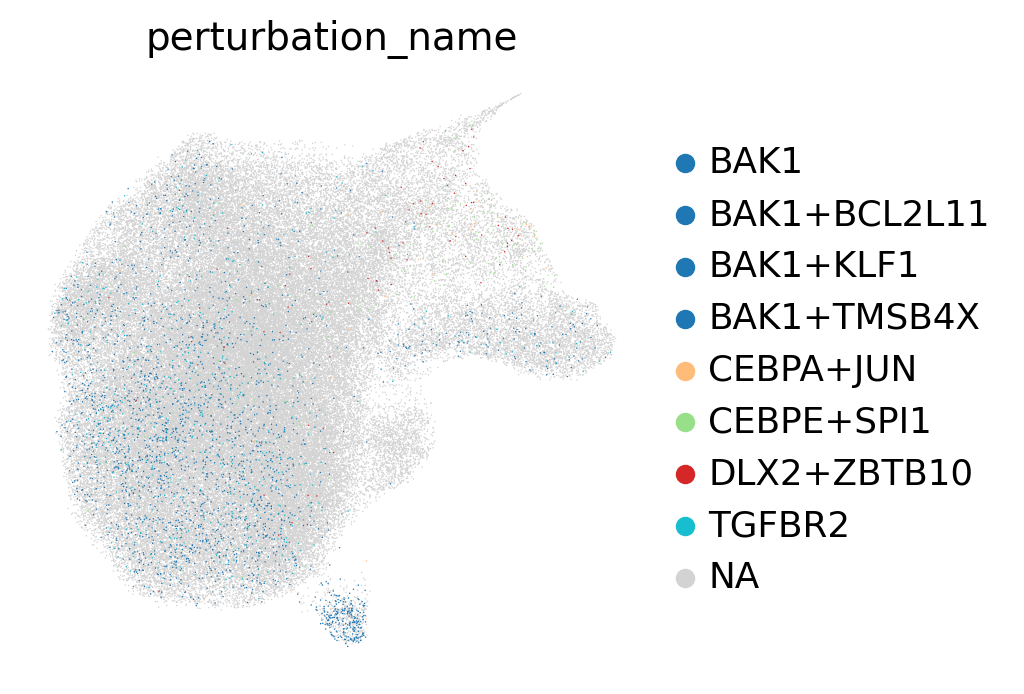

In [13]:
sc.pl.embedding(adata, color='perturbation_name', groups=high+low+['BAK1+BCL2L11', 'BAK1+KLF1', 'BAK1+TMSB4X'], basis='X_umap_mae_0', palette='tab20')

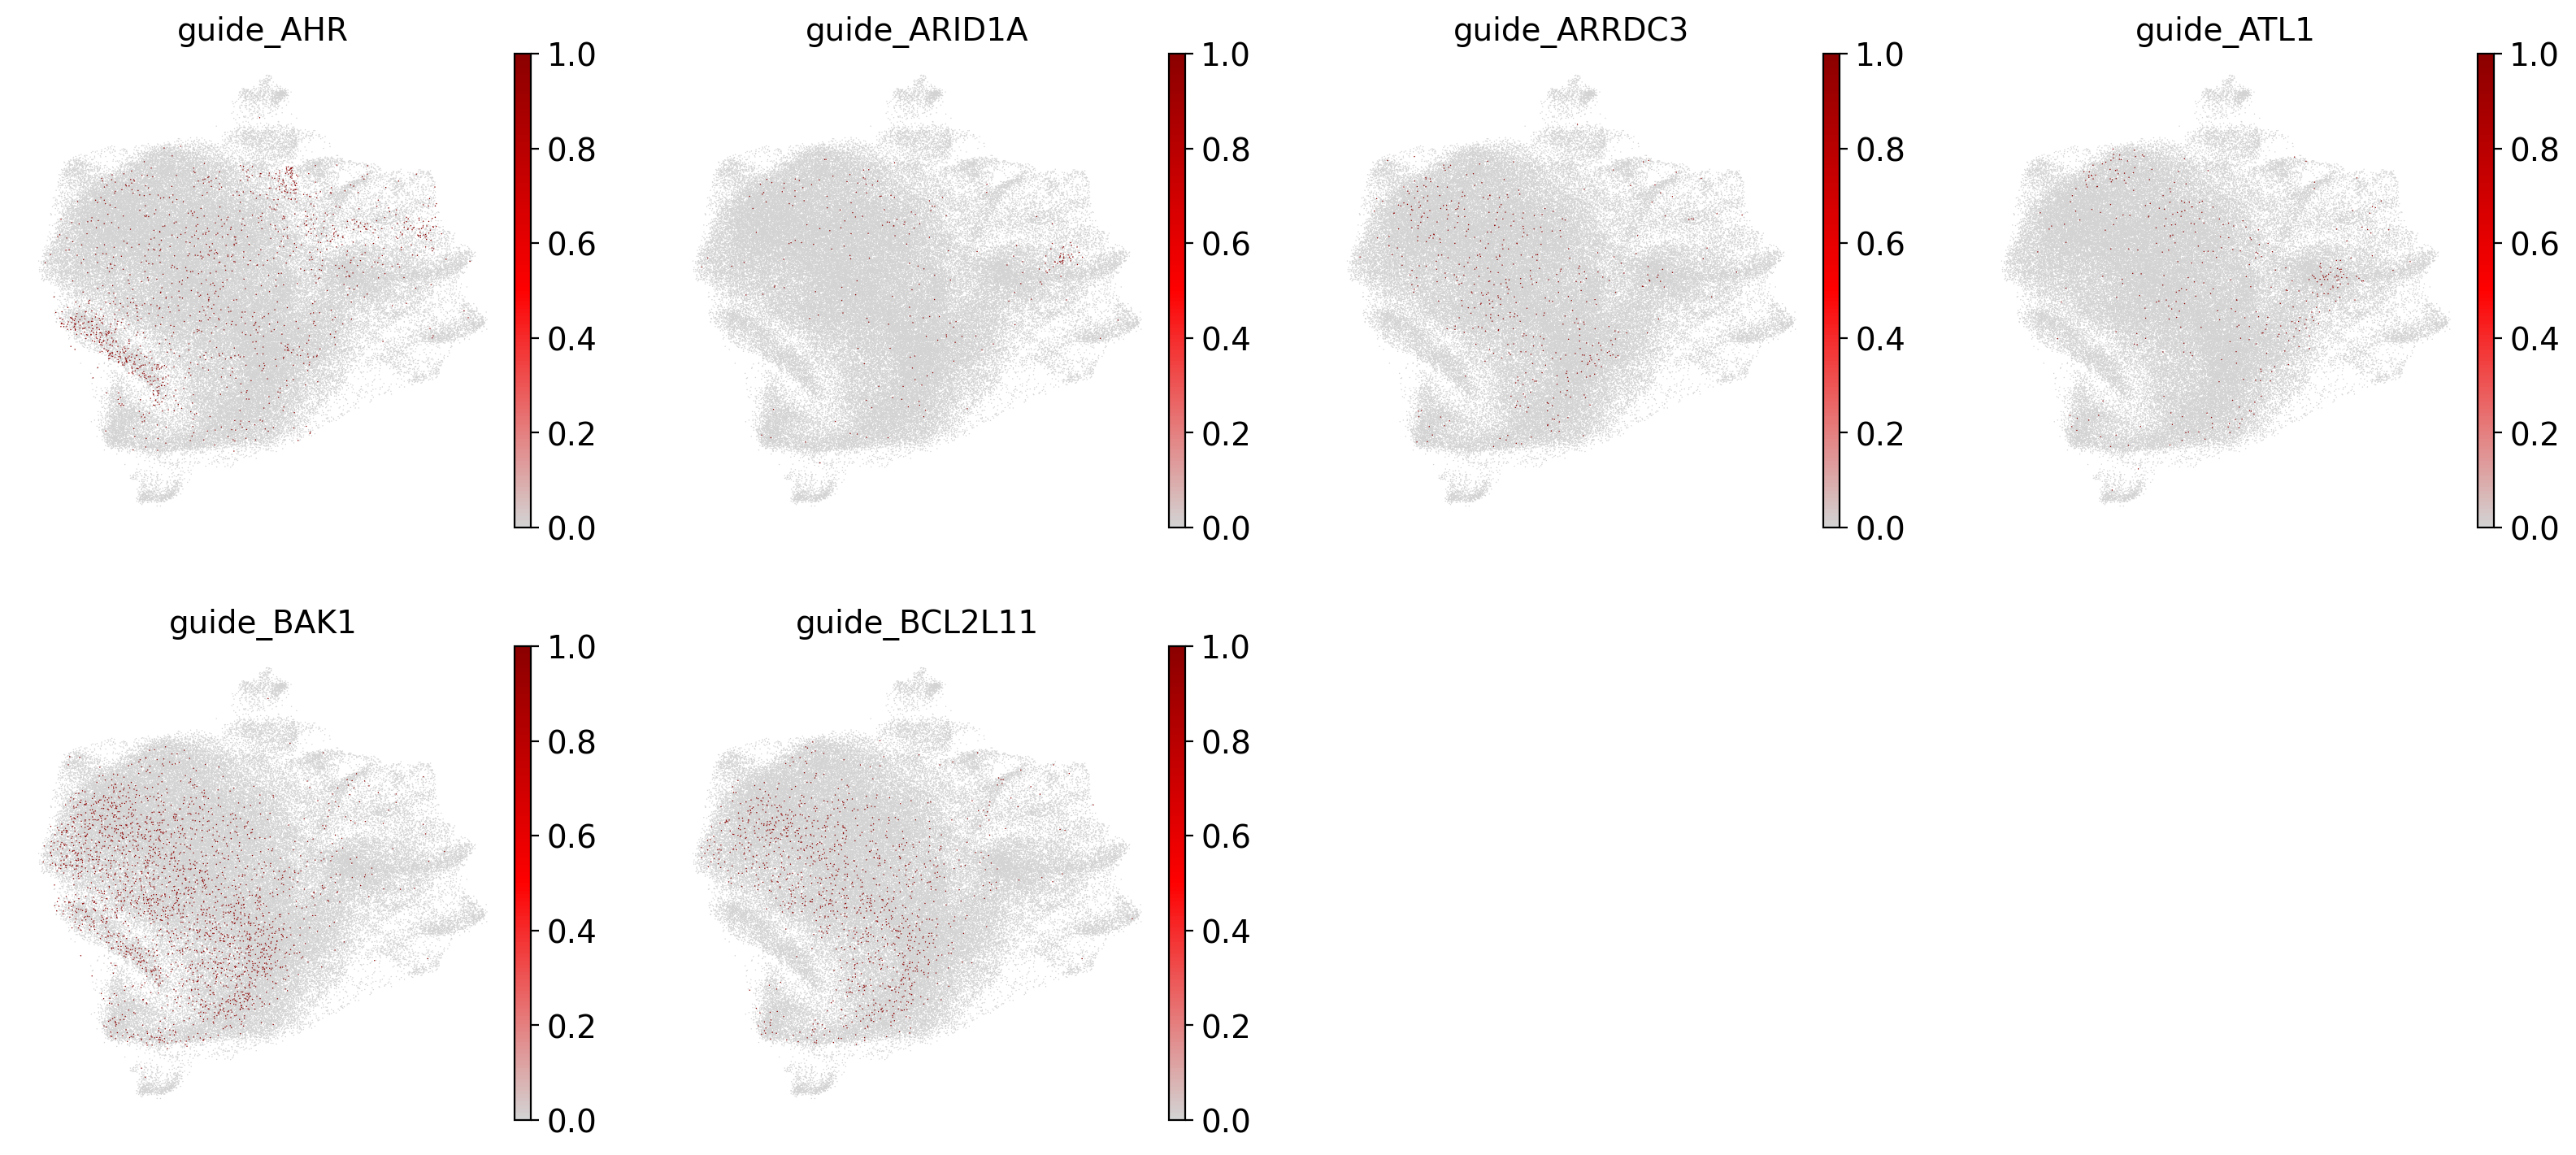

In [16]:
sc.pl.embedding(adata, color=['guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11'], basis='X_umap_nb_0', cmap=gray_red)

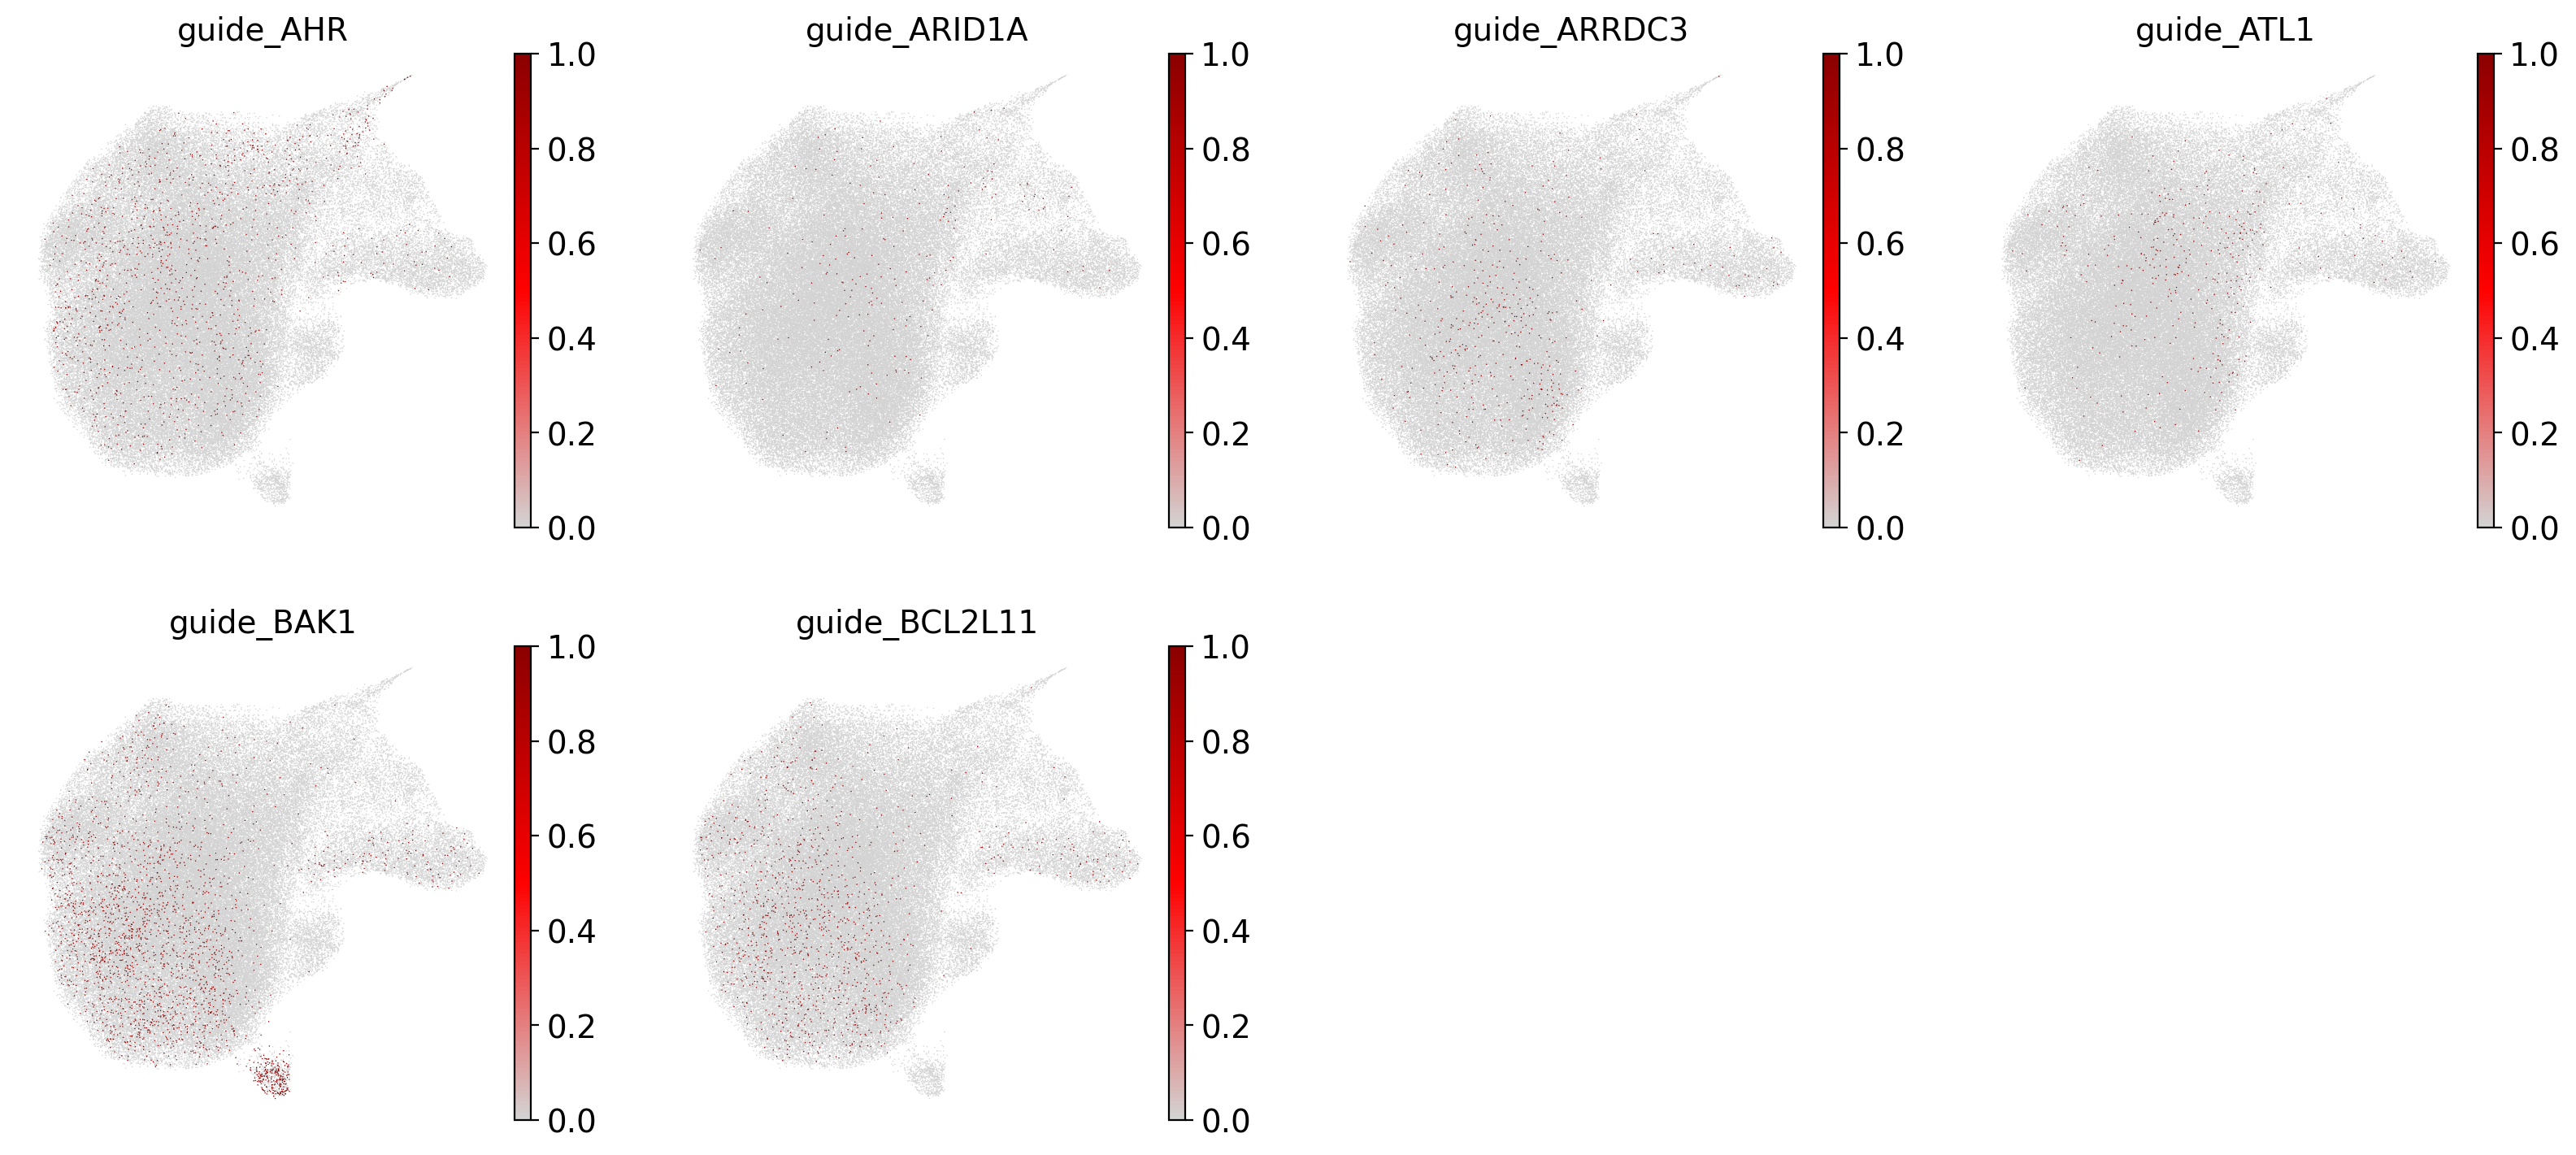

In [17]:
sc.pl.embedding(adata, color=['guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11'], basis='X_umap_mae_0', cmap=gray_red)

## quantitatively:

In [19]:
import scib_metrics
from scib_metrics import lisi_knn

In [25]:
labels = adata.obs.perturbation_name.values
labels = np.asarray(pd.Categorical(labels).codes)
adata.obs['mae_lisi'] = lisi_knn(adata.obsp['nn_mae_distances'], labels, perplexity=None)
adata.obs['nb_lisi'] = lisi_knn(adata.obsp['nn_nb_distances'], labels, perplexity=None)

In [26]:
adata.obs['mae_lisi'].mean()

2.4128082

In [27]:
adata.obs['nb_lisi'].mean()

2.2938519

In [31]:
lisi = adata.obs[['nb_lisi', 'mae_lisi', 'perturbation_name']].groupby('perturbation_name').mean()
lisi['mae-nb'] = lisi['mae_lisi'] - lisi['nb_lisi']

In [41]:
lisi[lisi['mae-nb'] > .4]

nb_lisi  mae_lisi    mae-nb
perturbation_name                              
CBFA2T3+FEV        1.860188  2.382040  0.521852
COL2A1             1.732082  2.359271  0.627190
COL2A1+KLF1        1.807919  2.345671  0.537753
DUSP9+SNAI1        2.010801  2.446311  0.435509
FEV                1.849188  2.319103  0.469914
FEV+ISL2           1.922557  2.346529  0.423972
IRF1               1.551632  2.420636  0.869004
IRF1+SET           1.358655  1.842252  0.483597
SGK1+TBX2          2.106194  2.506992  0.400798
SLC4A1             1.549034  2.365206  0.816171
SPI1               1.948156  2.457809  0.509653

In [38]:
import matplotlib.pyplot as plt

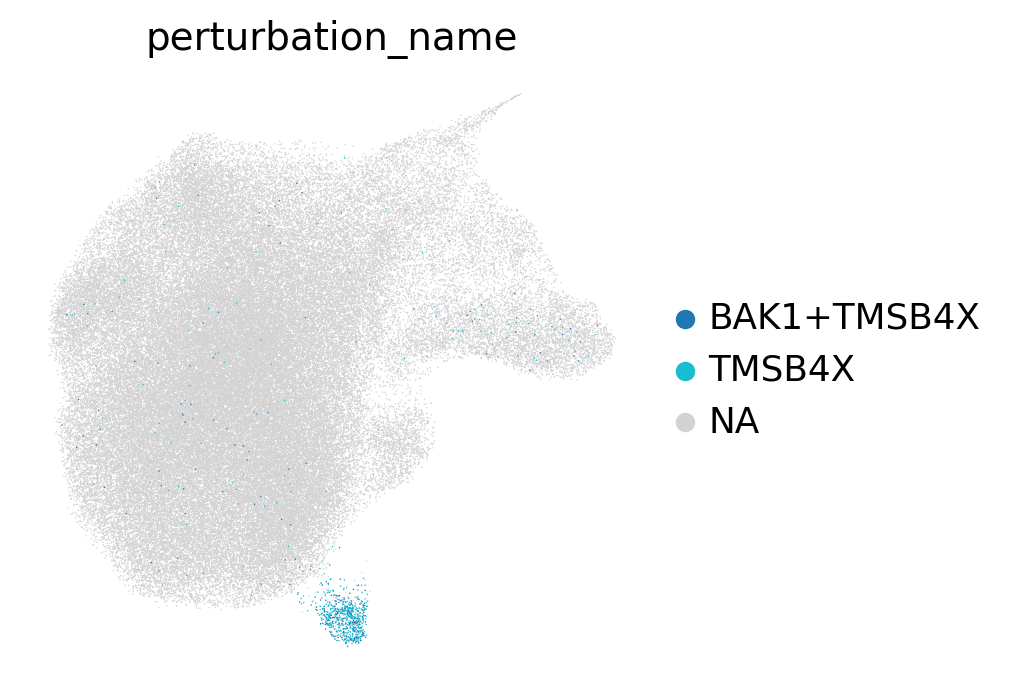

In [55]:
mae_better = list(lisi[lisi['mae-nb'] < -.3].index)
sc.pl.embedding(adata, color='perturbation_name', basis='X_umap_mae_0', groups=mae_better, palette='tab20')

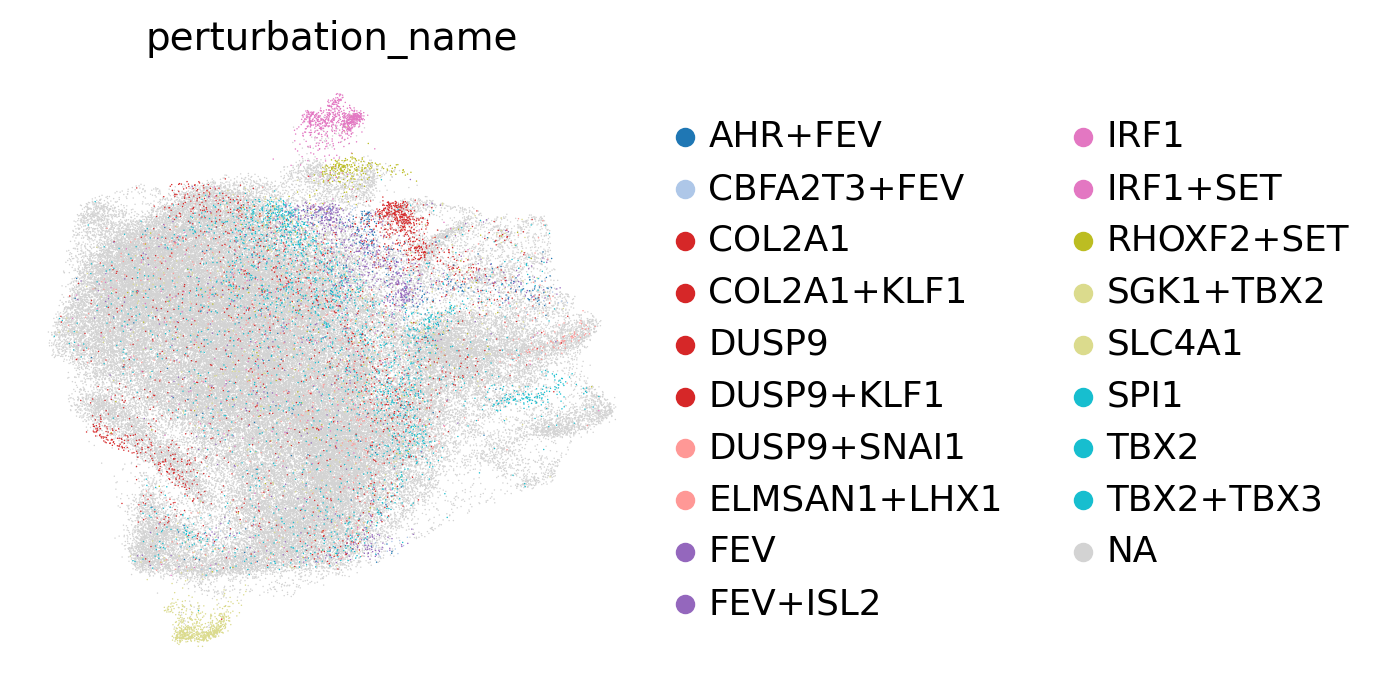

In [56]:
nb_better = list(lisi[lisi['mae-nb'] > .3].index)
sc.pl.embedding(adata, color='perturbation_name', basis='X_umap_nb_0', groups=nb_better, palette='tab20')

Where they both perform well:

In [69]:
cutoff = np.quantile(np.array(list(lisi['mae_lisi'].values) + list(lisi['nb_lisi'].values)), .1)

In [70]:
cutoff

2.188407826423645

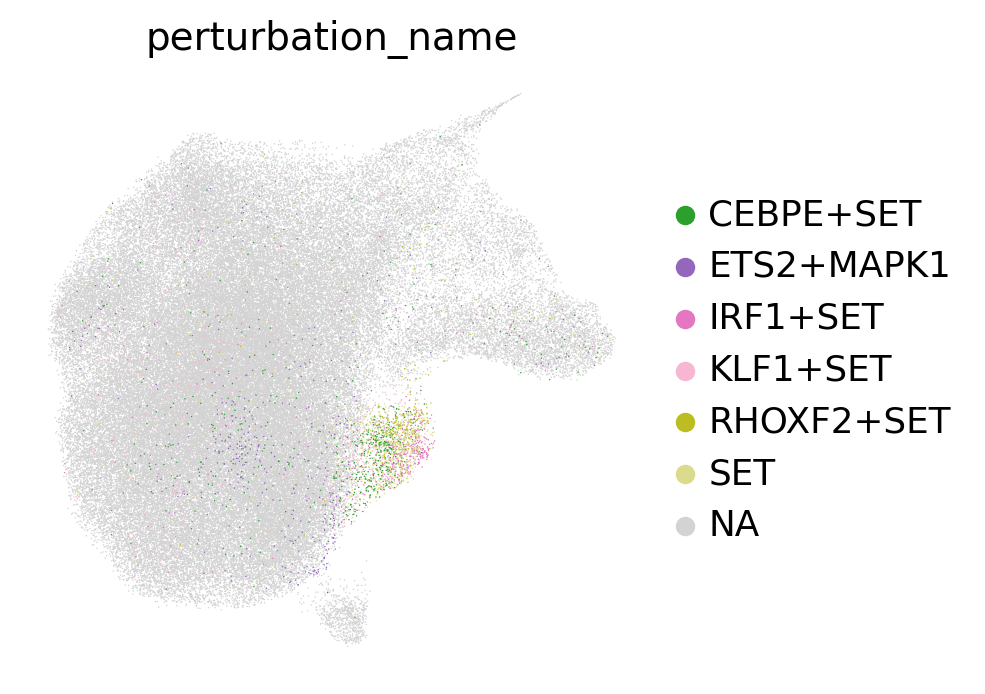

In [71]:
both_good = list(set(lisi[lisi['mae_lisi'] < cutoff].index) & set(lisi[lisi['nb_lisi'] < cutoff].index))
sc.pl.embedding(adata, color='perturbation_name', basis='X_umap_mae_0', groups=both_good, palette='tab20')

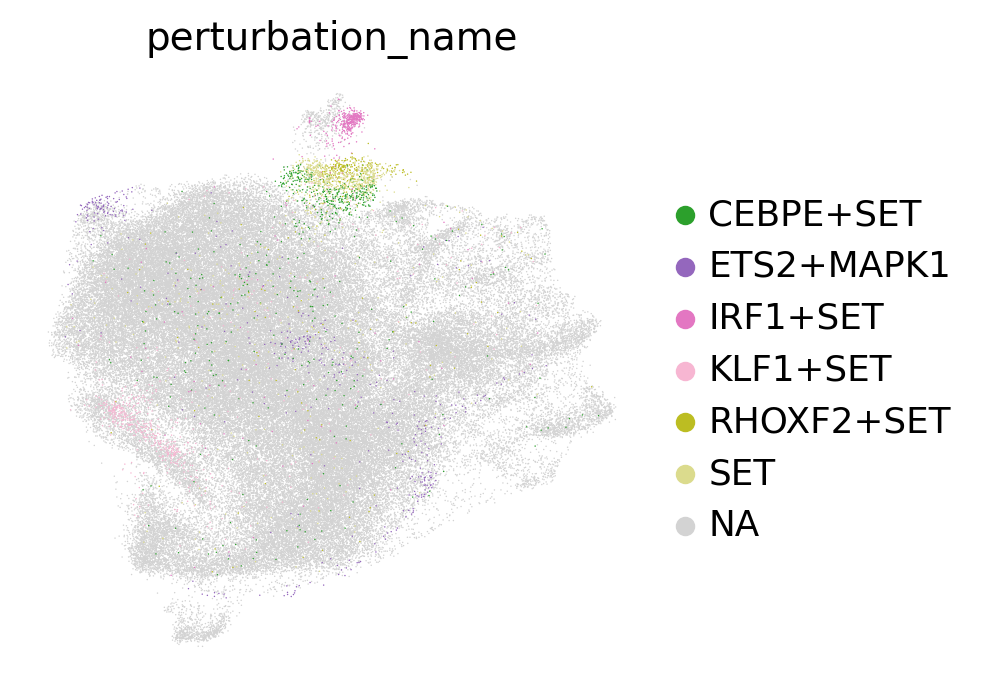

In [72]:
sc.pl.embedding(adata, color='perturbation_name', basis='X_umap_nb_0', groups=both_good, palette='tab20')

In [44]:
from utils import scanpy_setup

In [45]:
scanpy_setup(adata)

In [77]:
sc.pp.neighbors(adata, metric='euclidean')
sc.tl.umap(adata)

In [80]:
?sc.pp.neighbors

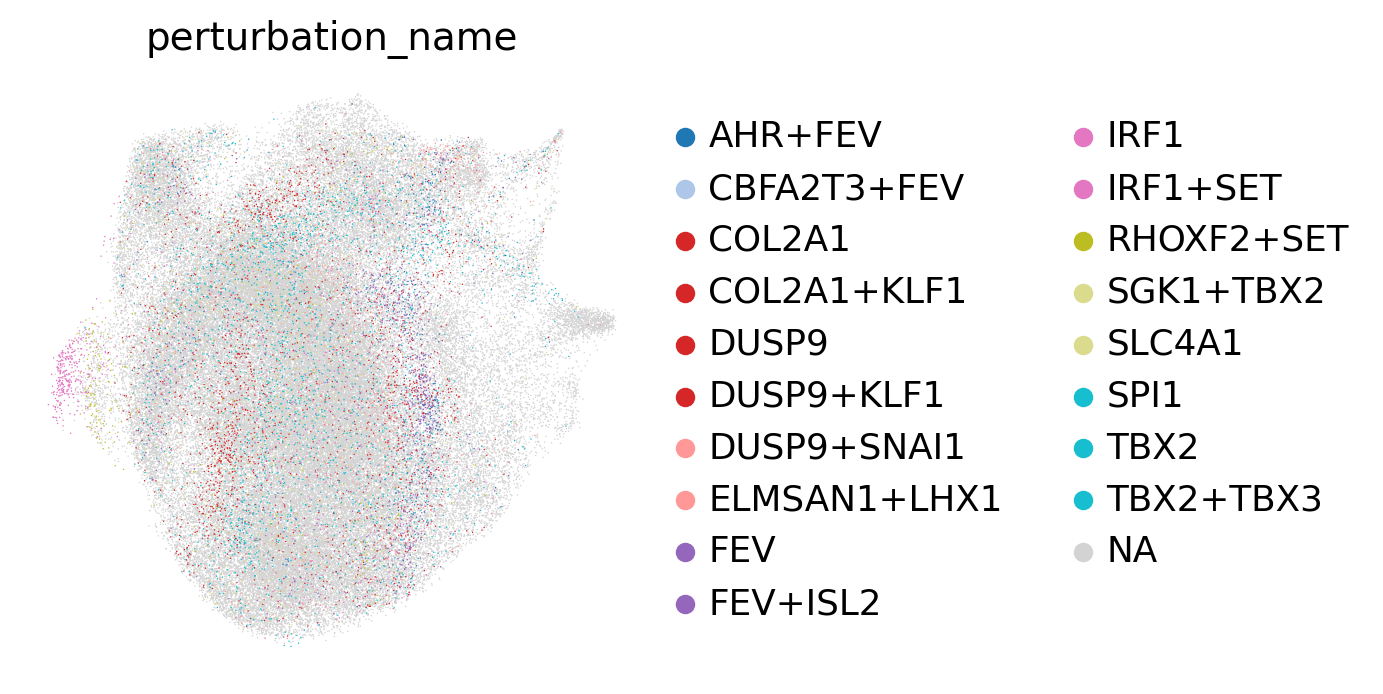

In [82]:
sc.pl.umap(adata, color='perturbation_name', groups=nb_better, palette='tab20')

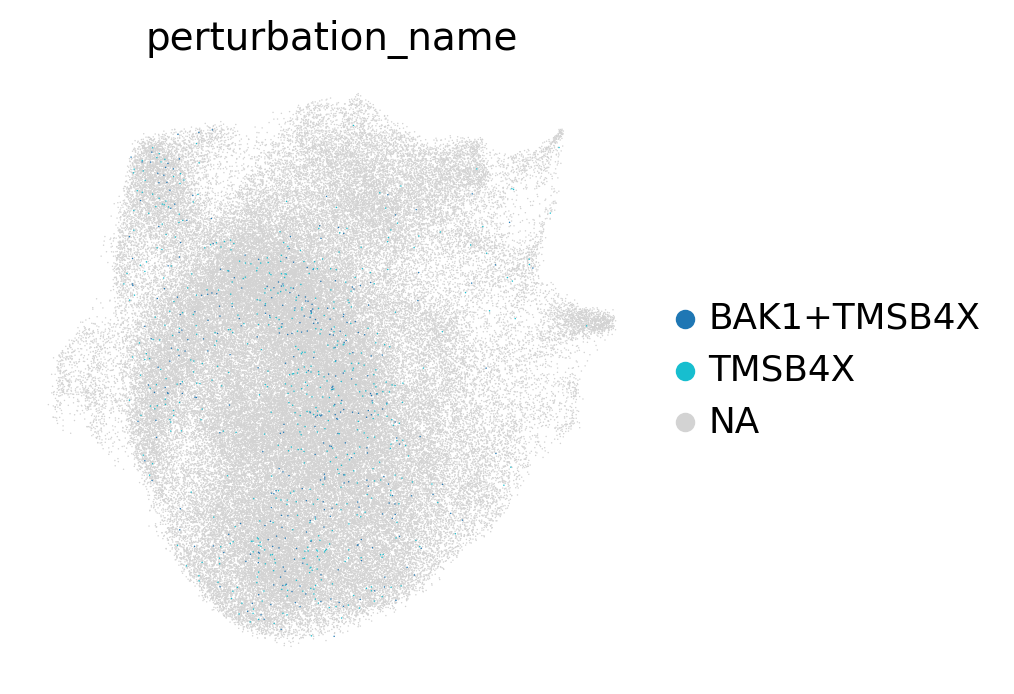

In [79]:
sc.pl.umap(adata, color='perturbation_name', groups=mae_better, palette='tab20')